In [69]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import math


In [70]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [71]:
selected_feature = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
parameters = {}
parameters['selected_feature'] = selected_feature

In [72]:
def cleanup_data(train_df, test_df):
    age_mean = pd.concat([train_df['Age'], test_df['Age']], ignore_index=True).mean()
    fare_mean = pd.concat([train_df['Fare'], test_df['Fare']], ignore_index=True).mean()
    
    train = train_df[['Survived'] + selected_feature].copy()
    
    train['Sex'] = train['Sex'].map({'male': 1, 'female': 0}).astype(int)
    train['Age'] = train['Age'].fillna(age_mean)
    train = train.dropna()
    train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    test = test_df[selected_feature].copy()
    test['Sex'] = test['Sex'].map({'male': 1, 'female': 0}).astype(int)
    test['Age'] = test['Age'].fillna(age_mean)
    test['Fare'] = test['Fare'].fillna(fare_mean)
    test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    return train, test

train, test = cleanup_data(train_df, test_df)

In [73]:
def feature_scaling(parmeters):
    def get_mean(data_list):
        return pd.concat(data_list, ignore_index=True).mean()
    
    def get_std(data_list):
        return pd.concat(data_list, ignore_index=True).std()

    def get_min(data_list):
        return pd.concat(data_list, ignore_index=True).min()

    def get_max(data_list):
        return pd.concat(data_list, ignore_index=True).max()

    for feature in parameters['selected_feature']:
        if parameters['feature_scaling'] == 'rescaling':
            data_list = [train[feature], test[feature]]
            min_ = get_min(data_list)
            max_ = get_max(data_list)
            train[feature] = (train[feature] - min_) / (max_ - min_)
            test[feature] = (test[feature] - min_) / (max_ - min_)
        elif parameters['feature_scaling'] == 'mean_normalization':
            data_list = [train[feature], test[feature]]
            mean = get_mean(data_list)
            min_ = get_min(data_list)
            max_ = get_max(data_list)
            train[feature] = (train[feature] - mean) / (max_ - min_)
            test[feature] = (test[feature] - mean) / (max_ - min_)
        else:
            data_list = [train[feature], test[feature]]
            mean = get_mean(data_list)
            std = get_std(data_list)
            train[feature] = (train[feature] - mean) / std
            test[feature] = (test[feature] - mean) / std

parameters['feature_scaling'] = 'standardization'
feature_scaling(parameters)

In [74]:
m = int(train.values.shape[0] * 0.7)
train_X = train[selected_feature].values[:m, :]
train_Y = train['Survived'].values.reshape(-1, 1)[:m, :]
valid_X = train[selected_feature].values[m:, :]
valid_Y = train['Survived'].values.reshape(-1, 1)[m:, :]
test_X = test[selected_feature].values
print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)
print(test_X.shape)

(622, 7) (622, 1)
(267, 7) (267, 1)
(418, 7)


In [75]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m,1))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k + 1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k + 1) * mini_batch_size, :]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, :]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [76]:
def make_model(parameters):
    num_feature = len(parameters['selected_feature'])
    X = tf.placeholder(tf.float32, [None, num_feature])
    Y = tf.placeholder(tf.float32, [None, 1])

    layers_dim = parameters['layers_dim']
    fc = tf.contrib.layers.stack(X, tf.contrib.layers.fully_connected, layers_dim)
    hypothesis = tf.contrib.layers.fully_connected(fc, 1, activation_fn=None)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=hypothesis, labels=Y)
    cost = tf.reduce_mean(loss)
    
    learning_rate = parameters['learning_rate']
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    prediction = tf.round(tf.sigmoid(hypothesis))
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model = {'X': X, 'Y': Y, 'hypothesis': hypothesis, 'cost': cost,
             'train_op': train_op, 'prediction': prediction, 'accuracy': accuracy}
    
    return model

In [77]:
def train(parameters, model):
    num_epochs = parameters['num_epochs']
    minibatch_size = parameters['minibatch_size']
    train_size = train_X.shape[0]
    saver = tf.train.Saver()
    epoch_list = []
    cost_list = []
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(train_size / minibatch_size)
            minibatches = random_mini_batches(train_X, train_Y, minibatch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                feed_dict = {model['X'] : minibatch_X, model['Y'] : minibatch_Y}
                _ ,minibatch_cost = sess.run([model['train_op'], model['cost']], feed_dict= feed_dict)
                epoch_cost += minibatch_cost / num_minibatches
            if parameters['print'] and (epoch % parameters['print_freq'] == 0):
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if parameters['save_cost'] and (epoch % parameters['save_cost_freq'] == 0):
                epoch_list.append(epoch)
                cost_list.append(epoch_cost)
        saver.save(sess, parameters['model_name'])
    return {'epoch_list': epoch_list, 'cost_list' : cost_list}

In [78]:
# set model parameters
parameters['layers_dim'] = [14]
parameters['learning_rate'] = 0.01
# set train parameters (hyper parameter)
parameters['num_epochs'] = 2000
parameters['minibatch_size'] = 16
# set option parameters
parameters['model_name'] = './data/titanic'
parameters['print'] = True
parameters['print_freq'] = 100
parameters['save_cost'] = True
parameters['save_cost_freq'] = 10

for k, v in parameters.items():
    print(k, '=', v)

selected_feature = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
feature_scaling = standardization
layers_dim = [14]
learning_rate = 0.01
num_epochs = 2000
minibatch_size = 16
model_name = ./data/titanic
print = True
print_freq = 100
save_cost = True
save_cost_freq = 10


In [79]:
with tf.Graph().as_default():
    model = make_model(parameters)
    plot_data = train(parameters, model)

Cost after epoch 0: 0.614459
Cost after epoch 100: 0.397611
Cost after epoch 200: 0.386555
Cost after epoch 300: 0.374001
Cost after epoch 400: 0.371001
Cost after epoch 500: 0.367808
Cost after epoch 600: 0.367147
Cost after epoch 700: 0.366214
Cost after epoch 800: 0.364871
Cost after epoch 900: 0.362433
Cost after epoch 1000: 0.360196
Cost after epoch 1100: 0.357505
Cost after epoch 1200: 0.354845
Cost after epoch 1300: 0.354299
Cost after epoch 1400: 0.353876
Cost after epoch 1500: 0.353257
Cost after epoch 1600: 0.352732
Cost after epoch 1700: 0.352966
Cost after epoch 1800: 0.352215
Cost after epoch 1900: 0.352149


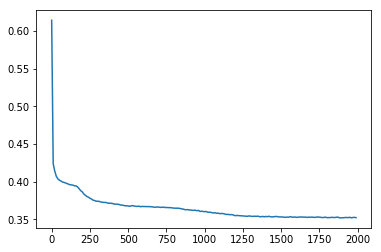

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
print
if parameters['save_cost']:
    plt.plot(plot_data['epoch_list'], plot_data['cost_list'])

In [1]:
def evaluate(parameters, model):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['model_name'])
        print ("Train Accuracy:", model['accuracy'].eval({model['X']: train_X, model['Y']: train_Y}))
        print ("Valid Accuracy:", model['accuracy'].eval({model['X']: valid_X, model['Y']: valid_Y}))

In [48]:
with tf.Graph().as_default():
    model = make_model(parameters)
    evaluate(parameters, model)

INFO:tensorflow:Restoring parameters from ./data/titanic
Train Accuracy: 0.87942123
Valid Accuracy: 0.80898875


In [49]:
def predict(parameters, model):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['model_name']) 
        return model['prediction'].eval({model['X']: test_X})

In [50]:
answer = pd.DataFrame(test_df['PassengerId'], columns=['PassengerId'])
with tf.Graph().as_default():
    model = make_model(parameters)
    test_Y = predict(parameters, model)
    answer['Survived'] = test_Y.astype(int)
answer.to_csv('answer.csv', index=False)

INFO:tensorflow:Restoring parameters from ./data/titanic


In [68]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(train_X, train_Y)
linear_match = np.sum(test_Y == np.round(linear_regressor.predict(test_X)))
print(f'Linear Model Accuracy of scikit-learn: {linear_match / test_Y.shape[0]}')

logistic_regressor = linear_model.LogisticRegression()
logistic_regressor.fit(train_X, train_Y)
pred = logistic_regressor.predict(test_X)
print(f'Logistic Model Accuracy of scikit-learn: {accuracy_score(test_Y, pred)}')



match ratio linear_model of scikit-learn: 0.8995215311004785
match ratio with logistic_model of scikit-learn: 0.8971291866028708
